# COS597N Project Notebook

In [55]:
import pickle
import os
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer, AutoModel, AutoTokenizer, AutoModelForTokenClassification
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, log_loss, accuracy_score, matthews_corrcoef
from sklearn.utils import shuffle
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.patches import Patch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
import re
import tqdm
import torch.nn.functional as F
from datetime import datetime
from copy import deepcopy
from scipy.special import softmax

In [2]:
path_to_checkpt = "/scratch/network/yc1709/checkpoint-final/"

In [36]:
path_baseline = "/scratch/network/yc1709/baseline_weights/baseline_outputs/"
path_subset = "/scratch/network/yc1709/subset_weights/custom_modified_best_model.pth"

In [13]:
tokenizer = AutoTokenizer.from_pretrained(path_to_checkpt)
model = AutoModelForTokenClassification.from_pretrained(path_to_checkpt)
baseline_model = AutoModelForTokenClassification.from_pretrained(path_baseline)
# subset_model = AutoModelForTokenClassification.from_pretrained(path_subset)
model = model.eval()
baseline_model = baseline_model.eval()
# subset_model = subset_model.eval()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [73]:
class CustomBERTClassifier(nn.Module):
    def __init__(self, path, num_classes, plddt = False):
        super(CustomBERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(path)
        self.dropout = nn.Dropout(0.1)  # Adjust dropout rate as needed
        print(self.bert.config.hidden_size)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)
        self.plddt = plddt
        if plddt:
            self.fc = nn.Linear(self.bert.config.hidden_size + 1, num_classes)

    def forward(self, input_ids, attention_mask, plddts=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state
        # if self.plddt:
        if plddts is not None and self.plddt:
            pooled_output = torch.concat((pooled_output, plddts.unsqueeze(-1)), dim=2)
        pooled_output = self.dropout(pooled_output)
        logits = self.fc(pooled_output)
        return logits
def model_init():
#     model = AutoModelForTokenClassification.from_pretrained(PRETRAINED_MODEL, num_labels=NUM_CLASSES)
    model = CustomBERTClassifier(path_to_checkpt, 2, plddt=True)
    return model

In [69]:
subset_model = model_init()
# subset_model = AutoModelForTokenClassification.from_pretrained(path_to_checkpt)
dic = torch.load(path_subset,map_location=torch.device('cpu'))
subset_model.load_state_dict(dic)
subset_model.eval()

Some weights of RobertaModel were not initialized from the model checkpoint at /scratch/network/yc1709/checkpoint-final/ and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


768


RuntimeError: Error(s) in loading state_dict for CustomBERTClassifier:
	size mismatch for fc.weight: copying a param with shape torch.Size([2, 769]) from checkpoint, the shape in current model is torch.Size([2, 768]).

In [70]:
def get_out(sent,tokenizer,model):
    encoded = tokenizer.encode_plus(sent, return_tensors="pt")
    with torch.no_grad():
        output = model(**encoded)
    return output

In [71]:
seq = "GSHMSDNEDNFDGDDFDDVEEDEGLDDLENAEEEGQENVEILPSGERPQANQKRITTPYMTKYERARVLGTRALQIAMCAPVMVELEGETDPLLIAMKELKARKIPIIIRRYLPDGSYEDWGVDELIITD"
out0 = get_out(seq,tokenizer,model)
print(len(seq))
outB = get_out(seq,tokenizer,baseline_model)
outC = get_out(seq,tokenizer,subset_model)

130


RuntimeError: mat1 and mat2 shapes cannot be multiplied (132x768 and 769x2)

/tmp/ipykernel_1122320/4023413562.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  plt.plot(F.softmax(torch.squeeze(out0['logits']))[1:-1,1].detach().numpy(), linewidth=3, label="DR-BERT Disordered region")
/tmp/ipykernel_1122320/4023413562.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  plt.plot(F.softmax(torch.squeeze(outB['logits']))[1:-1,1].detach().numpy(), linewidth=3, label="reproduction",c='Purple')


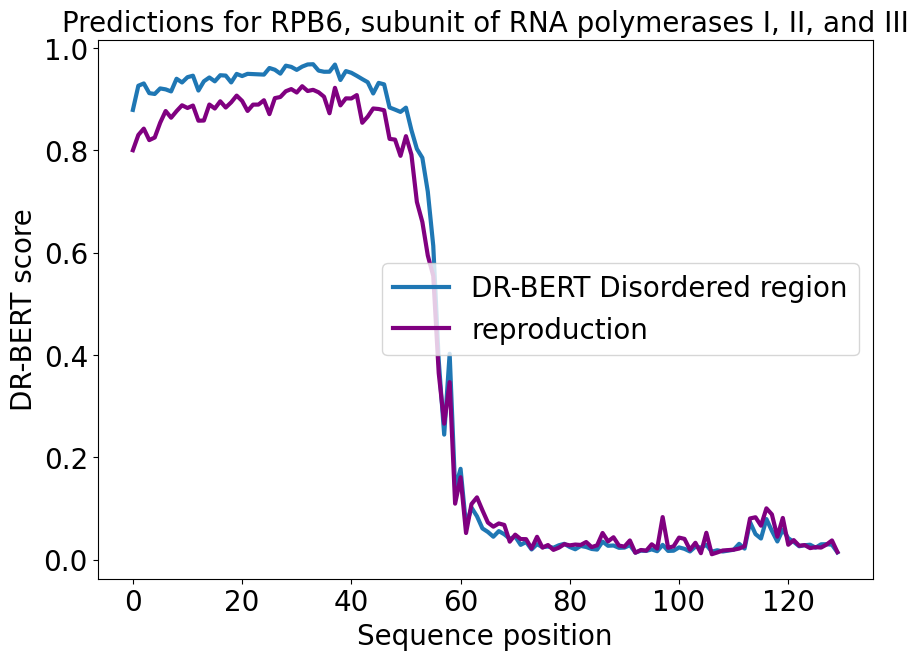

In [72]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(F.softmax(torch.squeeze(out0['logits']))[1:-1,1].detach().numpy(), linewidth=3, label="DR-BERT Disordered region")
plt.plot(F.softmax(torch.squeeze(outB['logits']))[1:-1,1].detach().numpy(), linewidth=3, label="reproduction",c='Purple')
# plt.plot(F.softmax(torch.squeeze(outC['logits']))[1:-1,1].detach().numpy(), linewidth=3, label="subset",c='Red')
ax.set_title('Predictions for RPB6, subunit of RNA polymerases I, II, and III',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Sequence position', fontsize=20)
plt.ylabel('DR-BERT score', fontsize=20)
plt.legend(fontsize=20)
plt.savefig('7dth_scores_pb.pdf')
plt.show()

In [24]:
protein_faa = "../data/protein.faa" #https://www.ncbi.nlm.nih.gov/gene/43740568

In [25]:
with open(protein_faa,"r") as file:
    data=file.read()
    lines="".join(data.split('\n')[1:])
print(len(lines))
protein_seq = lines[:1022]

1273


In [27]:
protein_seq
out0 = get_out(protein_seq,tokenizer,model)
print(len(protein_seq))
outB = get_out(protein_seq,tokenizer,baseline_model)

1022


/tmp/ipykernel_1122320/1004351214.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  plt.plot(F.softmax(torch.squeeze(out0['logits']))[1:-1,1].detach().numpy(), linewidth=3, label="Protein region")
/tmp/ipykernel_1122320/1004351214.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  plt.plot(F.softmax(torch.squeeze(outB['logits']))[1:-1,1].detach().numpy(), linewidth=3, label="Reproduced",c='Purple')


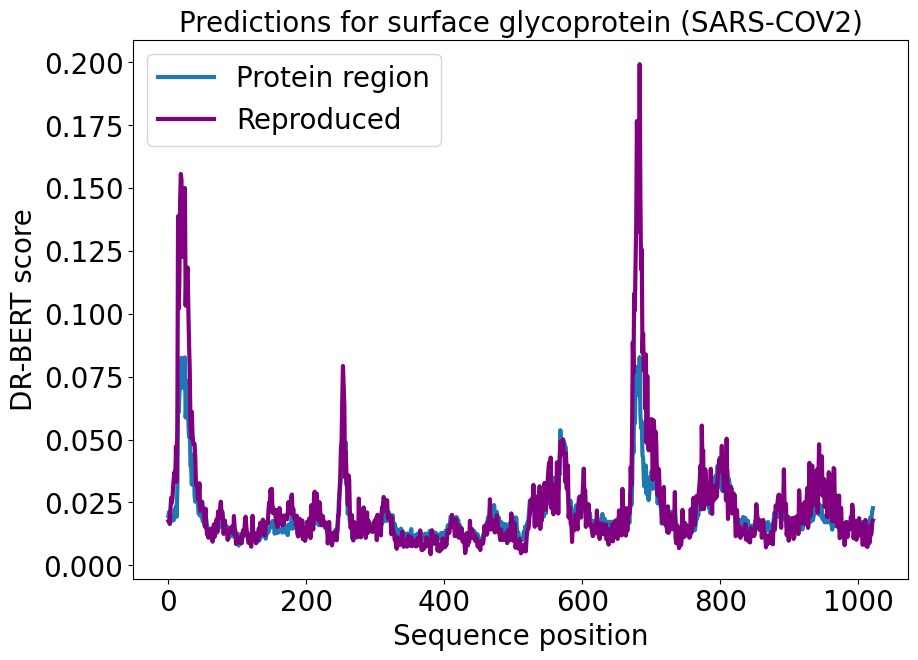

In [28]:
out0 = get_out(protein_seq,tokenizer,model)
fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(F.softmax(torch.squeeze(out0['logits']))[1:-1,1].detach().numpy(), linewidth=3, label="Protein region")
plt.plot(F.softmax(torch.squeeze(outB['logits']))[1:-1,1].detach().numpy(), linewidth=3, label="Reproduced",c='Purple')
ax.set_title('Predictions for surface glycoprotein (SARS-COV2)',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Sequence position', fontsize=20)
plt.ylabel('DR-BERT score', fontsize=20)
plt.legend(fontsize=20)
plt.savefig('7dth_scores_pb.pdf')
plt.show()

In [76]:
## P53

In [31]:
p53_seq = "MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLSPDDIEQWFTEDPGPDEAPRMPEAAPPVAPAPAAPTPAAPAPAPSWPLSSSVPSQKTYQGSYGFRLGFLHSGTAKSVTCTYSPALNKMFCQLAKTCPVQLWVDSTPPPGTRVRAMAIYKQSQHMTEVVRRCPHHERCSDSDGLAPPQHLIRVEGNLRVEYLDDRNTFRHSVVVPYEPPEVGSDCTTIHYNYMCNSSCMGGMNRRPILTIITLEDSSGNLLGRNSFEVRVCACPGRDRRTEEENLRKKGEPHHELPPGSTKRALPNNTSSSPQPKKKPLDGEYFTLQIRGRERFEMFRELNEALELKDAQAGKEPGGSRAHSSHLKSKKGQSTSRHKKLMFKTEGPDSD"
print(len(p53_seq))
out0 = get_out(p53_seq,tokenizer,model)
outB = get_out(p53_seq,tokenizer,baseline_model)

393


/tmp/ipykernel_1122320/3902309520.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  plt.plot(F.softmax(torch.squeeze(out0['logits']))[1:-1,1].detach().numpy(), linewidth=3, label="Protein region")
/tmp/ipykernel_1122320/3902309520.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  plt.plot(F.softmax(torch.squeeze(outB['logits']))[1:-1,1].detach().numpy(), linewidth=3, label="reproduction",c='Purple')


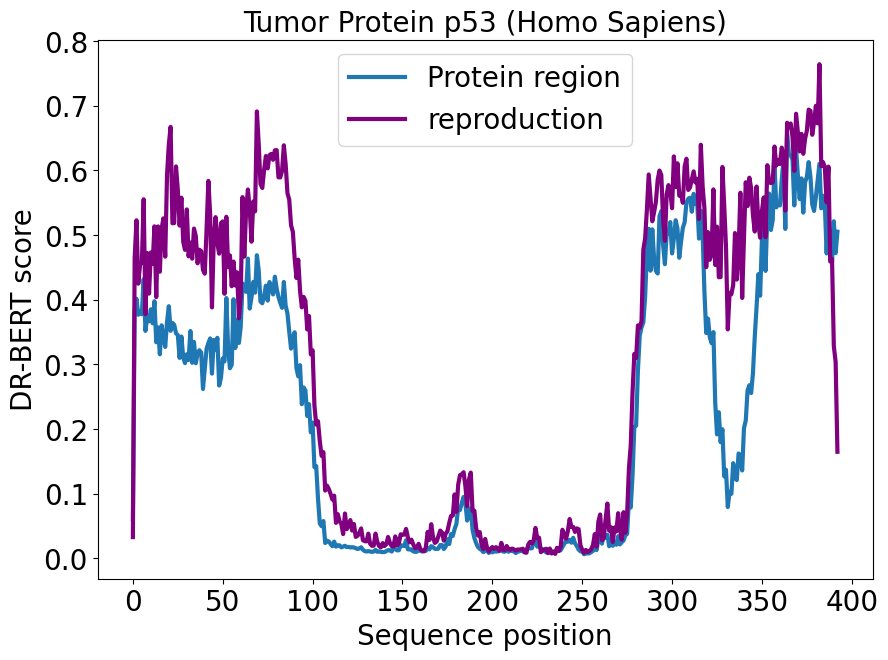

In [32]:
out0 = get_out(p53_seq,tokenizer,model)
fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(F.softmax(torch.squeeze(out0['logits']))[1:-1,1].detach().numpy(), linewidth=3, label="Protein region")
plt.plot(F.softmax(torch.squeeze(outB['logits']))[1:-1,1].detach().numpy(), linewidth=3, label="reproduction",c='Purple')
ax.set_title('Tumor Protein p53 (Homo Sapiens)',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Sequence position', fontsize=20)
plt.ylabel('DR-BERT score', fontsize=20)
plt.legend(fontsize=20)
plt.savefig('7dth_scores_pb.pdf')
plt.show()

In [2]:
df_train = pickle.load(open('../Datasets/train.pkl', "rb"))
df_val = pickle.load(open('../Datasets/val.pkl', "rb"))
df_test = pickle.load(open('../Datasets/caid.pkl', "rb"))

In [3]:
print(f'Training Dataset: {df_train.shape}')
print(f'Validation Dataset: {df_val.shape}')
print(f'Test Dataset: {df_test.shape}')

Training Dataset: (1569, 4)
Validation Dataset: (176, 4)
Test Dataset: (652, 3)


In [4]:
df_train.columns

Index(['Sequence', 'full', 'disprot_ID', 'intersect'], dtype='object')

In [5]:
df_train.head()

,Sequence,full,disprot_ID,intersect
0,MELITNELLYKTYKQKPVGVEEPVYDQAGDPLFGERGAVHPQSTLK...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",DP00675,False
5,MEDINFASLAPRHGSRPFMGNWQDIGTSNMSGGAFSWGSLWSGIKN...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",DP00808,False
7,MAAKFEVGSVYTGKVTGLQAYGAFVALDEETQGLVHISEVTHGFVK...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",DP00809,False
9,VVYTDCTESGQNLCLCEGSNVCGQGNKCILGSDGEKNQCVTGEGTP...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",DP00137,False
11,MNYIPTQTFYGRRWRPRPAARPWPLQATPVAPVVPDFQAQQMQQLI...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",DP00999,False


In [6]:
df_val.head()

,Sequence,full,disprot_ID,intersect
1823,MIPVTILCVLLCLNLAWAQDGKTTFEKEGGGGRGPRILENMHESSC...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",DP00233,False
1283,MGNLESTDGGPGEPPSVPLLLPPGKTPMPEPCELEERFALVLSSMN...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",DP02638,False
1868,MSGSVSGCGSGGCSIVWFRRDLRVEDNPALAAAVRAGPVIALFVWA...,"[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",DP00474,False
1416,MATVNQLVRKPRARKVAKSNVPALEACPQKRGVCTRVYTTTPKKPN...,"[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",DP00145,False
170,MAQWEMLQNLDSPFQDQLHQLYSHSLLPVDIRQYLAVWIEDQNWQE...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",DP00961,False


In [7]:
df_test.head()

,ID,Sequence,full
0,DP00084,MSDNDDIEVESDEEQPRFQSAADKRAHHNALERKRRDHIKDSFHSL...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,DP00182,MAPTKRKGSCPGAAPKKPKEPVQVPKLVIKGGIEVLGVKTGVDSFT...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,DP00206,MKAAQKGFTLIELMIVVAIIGILAAIAIPAYQDYTARAQLSERMTL...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,DP00334,MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQKD...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,DP00359,MMLTKSVVISRPAVRPVSTRRAVVVRASGQPAVDLNKKVQDAVKEA...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [8]:
df_full = pd.concat([df_train, df_val, df_test])

In [9]:
protein_lens = pd.Series([len(seq) for seq in df_full['Sequence']])
protein_lens.describe()

count     2397.000000
mean       549.033792
std        884.678317
min         19.000000
25%        204.000000
50%        392.000000
75%        651.000000
max      34350.000000
dtype: float64

Great, we can verify that none of the training and validation examples overlap with the test example.

In [10]:
MAX_LENGTH = 1024
EPOCHS = 10
LEARNING_RATE = 2e-6
BATCH_SIZE = 1
TOKENIZER_PATH =  "../checkpoint-final/"
# is this pretrained on protein sequences?
PRETRAINED_MODEL = "../checkpoint-final/"
NUM_CLASSES = 2
SCHEDULER='cosine_with_restarts'

In [11]:
class ProteinDegreeDataset(Dataset):

    def __init__(self, max_length, df, tokenizer, region_type):
        self.region_type = region_type # e.g. 'full'
        self.df = df
        self.seqs, self.labels = self.load_dataset()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def load_dataset(self):
        seq = list(self.df['Sequence']) # list of protein sequences
        label = list(self.df[self.region_type]) # list of list of labels
        return seq, label

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        seq = " ".join("".join(self.seqs[idx].split()))
        seq = re.sub(r"[UZOB]", "X", seq)

        seq_ids = self.tokenizer(seq, truncation=True, padding='max_length', max_length=self.max_length)
        sample = {key: torch.tensor(val) for key, val in seq_ids.items()}
        tens = torch.tensor(self.labels[idx], dtype=torch.long)
        sample['labels'] = F.pad(tens, (0, MAX_LENGTH - len(tens)))
        return sample

In [12]:
tokenizer = RobertaTokenizerFast.from_pretrained(TOKENIZER_PATH, do_lower_case=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [13]:
train_dataset = ProteinDegreeDataset(MAX_LENGTH, df_train, tokenizer, 'full')
val_dataset = ProteinDegreeDataset(MAX_LENGTH, df_val, tokenizer, 'full')

In [14]:
train_dataset[0]

{'input_ids': tensor([ 4, 21,  9,  ..., 14,  5,  0]),
 'attention_mask': tensor([1, 1, 1,  ..., 1, 1, 1]),
 'labels': tensor([0, 0, 0,  ..., 0, 0, 0])}

In [15]:
pd.Series(train_dataset[0]['input_ids']).value_counts()

5     93
15    83
12    83
7     82
8     67
9     63
16    53
11    52
13    51
6     48
10    47
14    45
17    41
18    40
20    39
23    37
19    31
21    23
24    23
22    21
4      1
0      1
dtype: int64

There are 25 tokens in the vocabulary (20 amino acids and ["unk_token": "[UNK]", "sep_token": "[SEP]", "pad_token": "[PAD]", "cls_token": "[CLS]", "mask_token": "[MASK]"]).

In [16]:
pd.Series(train_dataset[0]['attention_mask']).value_counts()

1    1024
dtype: int64

All tokens should be attended to.

In [17]:
print(len(train_dataset[0]['attention_mask']), len(train_dataset[0]['input_ids']), len(train_dataset[0]['labels']))

1024 1024 1024


Finally, note that all training points are truncated to be 1024 amino acids for training.

In [18]:
def precision_recall_f1_roc_convolve(name, logits, labels, convolution):
    convolved = np.convolve(np.array(logits).flatten(), np.array(convolution / np.sum(convolution)).flatten(), 'same')
    p = [(1 - i, i) for i in convolved]
    roc = [i[1] for i in p]
    roc2 = [i[0] for i in p]
    p = np.argmax(p, axis=-1)
    precision, recall, f1, support = precision_recall_fscore_support(labels, p)
    roc_auc = roc_auc_score(labels, roc)
    mcc = matthews_corrcoef(labels, p)
    return {
        f'precision_{name}':precision[1],
        f'recall_{name}':recall[1],
        f'f1_{name}':f1[1],
        f'roc_auc_{name}':roc_auc,
        f'mcc_{name}': mcc,
    }

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    logits = softmax(logits, axis=2)
    l = []
    for j, i in enumerate(labels):
        l = l + list(i[:len(df_val['Sequence'].iloc[j])])
    lg2 = []
    for k, i in enumerate(logits):
        lg2 = lg2 + [j[1] for j in i[:len(df_val['Sequence'].iloc[k])]]
    
    metrics = {}
    metrics.update(precision_recall_f1_roc_convolve('normal', lg2, l, [1]))
    metrics.update(precision_recall_f1_roc_convolve('wa5', lg2, l, [1,1,1,1,1]))
    metrics.update(precision_recall_f1_roc_convolve('wa9', lg2, l, [1,1,1,1,1,1,1]))
    metrics.update(precision_recall_f1_roc_convolve('wa15', lg2, l, [1]*15))
    metrics.update(precision_recall_f1_roc_convolve('linear5', lg2, l, [1,2,3,2,1]))
    metrics.update(precision_recall_f1_roc_convolve('linear9', lg2, l, [1,2,3,4,5,4,3,2,1]))
    metrics.update(precision_recall_f1_roc_convolve('linear15', lg2, l, [1,2,3,4,5,6,7,8,7,6,5,4,3,2,1]))
    metrics.update(precision_recall_f1_roc_convolve('quad5', lg2, l, [1,3,9,3,1]))
    metrics.update(precision_recall_f1_roc_convolve('quad9', lg2, l, [1,3,9,27,81,27,9,3,1]))
    metrics.update(precision_recall_f1_roc_convolve('quad15', lg2, l, [1,3,9,27,81,243,729,2187,729,243,81,27,9,3,1]))
    
    logits_path = OUTPUT_DIR + '/Logits/'
    if not os.path.isdir(logits_path):
        os.mkdir(logits_path)
    new_df = deepcopy(df_val)
    new_df['Logits'] = [[i[1] for i in x] for x in list(logits)]
    pickle.dump(new_df, open(logits_path + datetime.now().strftime("%H:%M:%S"), 'wb'))
    return metrics

In [19]:
OUTPUT_DIR = f'../Outputs'

In [24]:
training_args = TrainingArguments(
    output_dir = OUTPUT_DIR + '/Checkpoints',
    num_train_epochs = EPOCHS, # 10 epochs
    per_device_train_batch_size = 1,
    per_device_eval_batch_size = 16,
    warmup_steps = 1000,
    learning_rate = LEARNING_RATE, # 2e-06
    logging_dir = OUTPUT_DIR + '/Logs',
    logging_steps = 200,
    lr_scheduler_type=SCHEDULER, # cosine with restarts
    do_train = True,
    do_eval = True,
    evaluation_strategy = 'epoch', # evaluate at every epoch
    gradient_accumulation_steps = BATCH_SIZE,
#     fp16 = True,
#     fp16_opt_level = '02',
    save_strategy = 'epoch',
    load_best_model_at_end = True
)

In [26]:
from transformers import AutoModelForTokenClassification
def model_init():
    model = AutoModelForTokenClassification.from_pretrained(PRETRAINED_MODEL, num_labels=NUM_CLASSES)
    return model

In [27]:
trainer = Trainer(
    model_init=model_init,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    compute_metrics = compute_metrics,
)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [28]:
trainer.train()

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [30]:
!conda list torch

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
# packages in environment at /home/byw2/.conda/envs/dr-bert-env:
#
# Name                    Version                   Build  Channel
pytorch                   2.0.1           cpu_py39hab5cca8_0  
